#### Explore Dataset and Define Appropriate Classes
* The dataset consists of training data, validation data, and testing data.
* The training data consists of 5,216 chest x-ray images with 3,875 images shown to have pneumonia and 1,341 images shown to be normal.
* The validation data is relatively small with only 16 images with 8 cases of pneumonia and 8 normal cases.
* The testing data consists of 624 images split between 390 pneumonia cases and 234 normal cases.
* So the two classes we have, are the images with pneumonia and those without.

#### Related Work and performance
<img src = 'https://i.ibb.co/c2NtHN6/evaluation-1.png'  width = 800 height = 90>
<img src = 'https://i.ibb.co/6w2d343/evaluation2.png' width = 800 height = 70>

#### We will use pretrained mobilenet, densenet169 and stacked model of (mobilenet and densenet169)

#### Import Libraries

In [1]:
# making all imports 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img

import tensorflow as tf
import keras

import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Create the paths

In [2]:
main_dir = "./data/chest_xray/"
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

print("Working Directory Contents:", os.listdir(main_dir))

train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

Working Directory Contents: ['val', '.DS_Store', 'test', 'train']


#### Visualize data and employ appropriate preprocessing to X-ray images

* For image processing we create a function and put in lambda layer in our model

* For Xray-classification, the CLAHE and image normalization helps up to get better result. CLAHE is a variant of Adaptive
 histogram equalization (AHE) which takes care of over-amplification of the contrast.

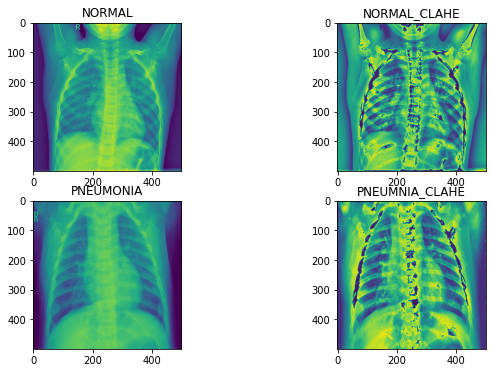

In [5]:
# Quick look to the images 
clahe = cv2.createCLAHE(clipLimit = 5)


img_name = 'IM-0115-0001.jpeg'
img_normal = cv2.imread('./data/chest_xray/train/NORMAL/' + img_name)
img_normal = cv2.resize(img_normal, (500,500))
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY)
img_normal_clahe = clahe.apply(img_normal) + 30



img_name_1 = 'person1000_virus_1681.jpeg'
img_pneumonia = cv2.imread('./data/chest_xray/train/PNEUMONIA/' + img_name_1)
img_pneumonia = cv2.resize(img_pneumonia, (500,500))
img_pneumonia = cv2.cvtColor(img_pneumonia, cv2.COLOR_BGR2GRAY)
img_pneumonia_clahe = clahe.apply(img_pneumonia) + 30


#-----------------------------------------------------------------------------------------#


fig, axs = plt.subplots(2,2,figsize=(10,6))
axs[0,0].imshow(img_normal)
axs[0,0].set_title("NORMAL")
axs[0,1].imshow(img_normal_clahe)
axs[0,1].set_title("NORMAL_CLAHE")
axs[1,0].imshow(img_pneumonia)
axs[1,0].set_title("PNEUMONIA")
axs[1,1].imshow(img_pneumonia_clahe)
axs[1,1].set_title("PNEUMNIA_CLAHE");


#### Create the generator for fitting to the model
* We need a generator because training big amount of images can take us to memory insufficient error

* Here the generator will do all our image preprocessing task for training

In [6]:
### here we will apply image augmentation only on the training images not on testing or validation
img_width , img_height = [224,224]
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


* Here we draw some batch to see how our image looks like after data augmentation

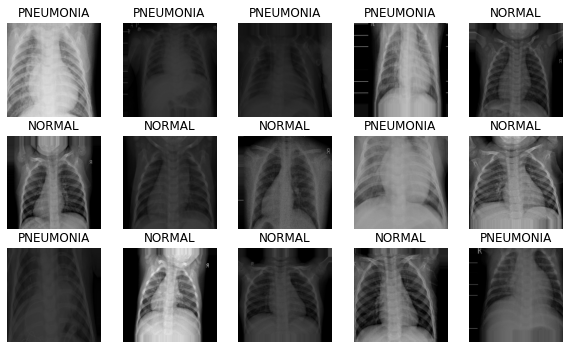

In [7]:

image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [8]:
nb_train_samples = 5216 # number of training samples
nb_validation_samples = 16 # number of validation samples
nb_test_samples = 624 # number of training samples
epochs = 20  # number of epochs we gonna run
batch_size  = 16 # batch size ( at every iteration it will take 16 batches for training)

### Define the model

* Here we are going to use Pretrained models for better accuracy

#### 1- DenseNet169 

In [9]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

base = DenseNet169(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
tf.keras.backend.clear_session()

for layer in base.layers:
    layer.trainable =  False # freezing densenet layers 

densenet_model = Sequential()
densenet_model.add(base)
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(256, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(BatchNormalization())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dropout(0.5))
densenet_model.add(Dense(1, activation='sigmoid'))

densenet_model.summary()

# defined optimizer
optm = Adam(lr=0.0001)
densenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=7,
                              verbose=1,
                              mode='max',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=3,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./densenet169.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

51879936/51877672 [==============================] - 5s 0us/step

In [11]:
### Training our model
dense_history = densenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
 60/326 [====>.........................] - ETA: 5:44 - loss: 0.6843 - accuracy: 0.6339 

KeyboardInterrupt: 

### Define functions for plotting and Testing

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# for plotting learning curve 
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = image/255
    image = cv2.resize(image, (224,224))
    return image


def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    final_base_pred  = np.where(np.array(base_pred)>0.5,1,0)
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, final_base_pred))
    matrix=confusion_matrix(actual_label, final_base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

In [ ]:
# for evaluation create a dataframe of test directory
test_data = []
test_normal_path = test_data_dir + '/NORMAL'
test_pneumonia_path = test_data_dir + '/PNEUMONIA'
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))
for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))    

# this test_df must contain the img_path and label column in order to run the function
test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)

In [ ]:
plot(dense_history)

In [ ]:
densenet_model = keras.models.load_model('./densenet169.h5')

In [ ]:
testing(densenet_model, test_df)

## MobilenetV2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base = MobileNetV2(weights = 'imagenet', include_top = False, input_shape= (224, 224, 3))
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

mobilenet_model = Sequential()
mobilenet_model.add(base)
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(256, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(1, activation='sigmoid'))

mobilenet_model.summary()

# defined optimizer
optm = Adam(lr=0.0001)
mobilenet_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.001,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=4,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./mobilenet.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


In [ ]:
### Training our model
mobilenet_history = mobilenet_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

In [ ]:
plot(mobilenet_history)

In [ ]:
mobilenet_model = keras.models.load_model('./mobilenet.h5')

In [ ]:
testing(mobilenet_model, test_df)

## Stacked Model (MobilenetV2, Densenet169)

In [ ]:
from keras.layers.merge import concatenate
from keras.layers import Input
import tensorflow as tf

input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))

#first model
base_mobilenet = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = input_shape)
base_densenet = DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_shape)

for layer in base_mobilenet.layers:
    layer.trainable =  False
for layer in base_densenet.layers:
    layer.trainable = False
    
model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet]) 

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)

stacked_model.summary()

# defined optimizer
optm = Adam(lr=0.0001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

# defining callbacks 

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)

model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [ ]:
### Training our model
stacked_history = stacked_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,
                           
                              callbacks=[EarlyStopping, model_save,rlr])

In [ ]:
stacked_model = keras.models.load_model('./stacked_model.h5')
testing(stacked_model,test_df)